In [1]:
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import StandardScaler # scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# Data identification number
DATA_ID = 1

# Model identification
MODEL_ID = 'DNN1'

# Output name
OUTPUT = 'DIF_FLUIDEZ'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

In [3]:
# Import  x and y arrays
x = joblib.load(f'{OUTPUT_FOLDER}/DATA_{DATA_ID}_numpy_x_{OUTPUT}.joblib')
y = joblib.load(f'{OUTPUT_FOLDER}/DATA_{DATA_ID}_numpy_y_{OUTPUT}.joblib')
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (803, 9)
y shape: (803,)


In [4]:
# Create a scaler for X and y
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on the target data and transform
x_scaled = scaler_x.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(-1)

# Exporting scaler
joblib.dump(scaler_x, f'{OUTPUT_FOLDER}/SCALER_X_{DATA_ID}_{MODEL_ID}_{OUTPUT}.joblib')
joblib.dump(scaler_y, f'{OUTPUT_FOLDER}/SCALER_Y_{DATA_ID}_{MODEL_ID}_{OUTPUT}.joblib')

print('x Scaler information:')
print('Means:', scaler_x.mean_)
print('Scales:', scaler_x.scale_)

print('y Scaler information:')
print('Means:', scaler_y.mean_)
print('Scales:', scaler_y.scale_)

x Scaler information:
Means: [186.70293411 261.20615162 333.59285352   8.97723859  18.61042158
   4.46825283 208.56081448 158.11071474 303.544538  ]
Scales: [  6.36067546   7.75225155   9.50909334   1.20782274   2.87265518
   1.76157561   7.30360612  13.39855298 120.91002904]
y Scaler information:
Means: [1.29705429]
Scales: [6.57255606]


In [5]:
# Split data into training and remaining (validation + test) sets
x_train_scaled, x_rem_scaled, y_train_scaled, y_rem_scaled = train_test_split(x_scaled, y_scaled, train_size=0.7, random_state=42)

# Split the remaining data into validation and test sets
x_val_scaled, x_test_scaled, y_val_scaled, y_test_scaled = train_test_split(x_rem_scaled, y_rem_scaled, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"x_val shape: {x_val_scaled.shape}")
print(f"y_val shape: {y_val_scaled.shape}")
print(f"x_test shape: {x_test_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

x_train shape: (562, 9)
y_train shape: (562,)
x_val shape: (192, 9)
y_val shape: (192,)
x_test shape: (49, 9)
y_test shape: (49,)


In [6]:
NEURONS_RATIO = 5 # neurons per features ratio
DROPOUT = 0.1

# Define the model
model = tf.keras.Sequential()

# Number of input features
num_features = x_train_scaled.shape[1]

# Function to determine the number of neurons in dense layers
def neurons(num_features, ratio):
    return int(num_features * ratio)

# Input layer with the correct shape
model.add(layers.Input(shape=(num_features,)))

# Dense layers with Dropout, Batch Normalization, and L2 regularization
model.add(layers.Dense(neurons(num_features, NEURONS_RATIO), 
                       activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01),
                       ))
model.add(layers.Dropout(DROPOUT))
model.add(layers.BatchNormalization())

model.add(layers.Dense(neurons(num_features, NEURONS_RATIO/2), 
                       activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01),
                       ))
model.add(layers.Dropout(DROPOUT/2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(neurons(num_features, NEURONS_RATIO/4), 
                       activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01),
                       ))
model.add(layers.Dropout(DROPOUT/4))
model.add(layers.BatchNormalization())

# Output layer
model.add(layers.Dense(1))

# Define the optimizer and compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=opt)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 45)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45)             │           180 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22)             │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11)             │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,039 (7.96 KB)

 Trainable params: 1,883 (7.36 KB)

 Non-trainable params: 156 (624.00 B)

In [7]:
# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# Add additional callbacks if needed (e.g., ReduceLROnPlateau)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2,
                                                 patience=10, 
                                                 min_lr=0.0001)

# Train the model
history = model.fit(x_train_scaled, 
                    y_train_scaled, 
                    batch_size=10, 
                    epochs=300, 
                    validation_data=(x_val_scaled, y_val_scaled), 
                    # callbacks=[early_stopping],
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

# Evaluate the model on the test data
test_loss = model.evaluate(x_test_scaled, y_test_scaled)
print(f"Test loss: {test_loss}")

Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.6517 - val_loss: 1.5312 - learning_rate: 5.0000e-04
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8173 - val_loss: 1.5762 - learning_rate: 5.0000e-04
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3254 - val_loss: 1.6232 - learning_rate: 5.0000e-04
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3098 - val_loss: 1.6571 - learning_rate: 5.0000e-04
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1662 - val_loss: 1.6227 - learning_rate: 5.0000e-04
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0426 - val_loss: 1.6276 - learning_rate: 5.0000e-04
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0718 - val_loss: 1.5939 - learning_rate: 5.0000e-04
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8571 - val_loss: 1.5629 - learning_rate: 5.0000e-04
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9209 - val_loss: 1.5231 - learning_

In [8]:
# Save the model in Keras native format
model.save(f'{OUTPUT_FOLDER}/MODEL_{DATA_ID}_{MODEL_ID}_{OUTPUT}.keras')

# Load the model
loaded_model = tf.keras.models.load_model(
    f'{OUTPUT_FOLDER}/MODEL_{DATA_ID}_{MODEL_ID}_{OUTPUT}.keras')

In [9]:
# Assuming you have your model predictions and actual values
y_test_pred_scaled = model.predict(x_test_scaled)
y_pred_scaled = model.predict(x_scaled)
residue_test = y_test_scaled.ravel() - y_test_pred_scaled.ravel()
residue = y_scaled.ravel() - y_pred_scaled.ravel()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [10]:
# Calculate RMSE
def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

rmse_dl = np.sqrt(model.evaluate(x_test_scaled, y_test_scaled, batch_size = 1000, verbose = 0))
print('\nRMSE:', rmse_dl)

# Calculate R-squared value
r2 = r2_score(y_test_scaled, y_test_pred_scaled)
print('Test data R²:', r2)

# Calculate R-squared value
r2 = r2_score(y_scaled, y_pred_scaled)
print('All data R²:', r2)


RMSE: 1.2791994945940233
Test data R²: 0.07817599695691868
All data R²: 0.21076744896263844


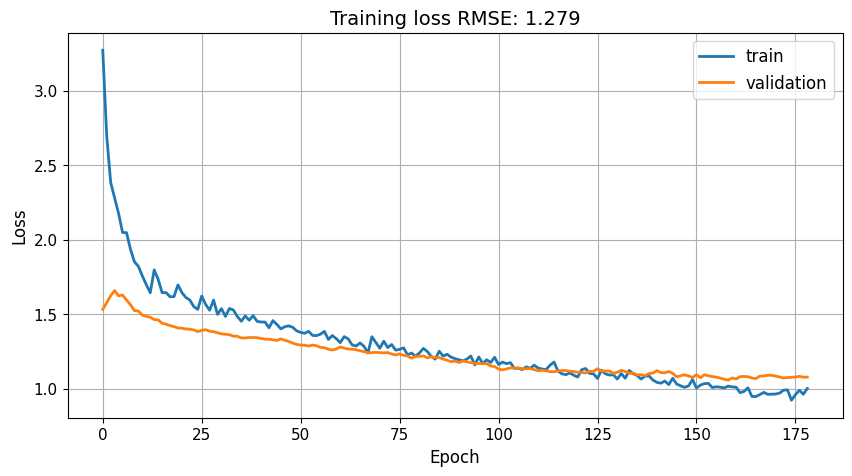

In [11]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], linewidth = 2)
plt.plot(history.history['val_loss'], linewidth = 2)
plt.title('Training loss RMSE: %.3f' %(rmse_dl), fontsize = 14)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.legend(['train', 'validation'], loc='upper right', fontsize = 12)
plt.grid()
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

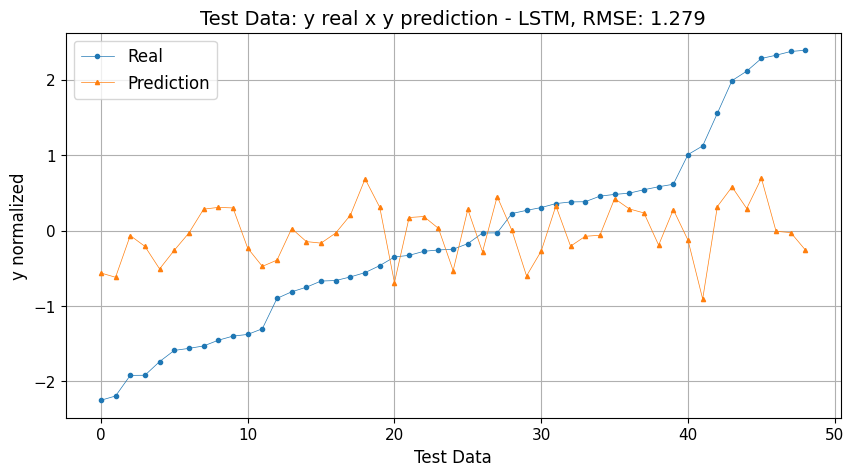

In [12]:
prediction_results = np.asarray(np.column_stack((y_test_scaled, y_test_pred_scaled)))
prediction_results = sorted(prediction_results, key= lambda x: x[0])
prediction_results = np.asarray(prediction_results)
plt.figure(figsize = (10,5))
plt.plot(np.asarray(np.asarray(prediction_results[:,0])), 
         linestyle='-', linewidth=0.5, marker='o', markersize=3, label = 'Real')
plt.plot(np.asarray(np.asarray(prediction_results[:,1])), 
         linestyle='-', linewidth=0.5, marker='^', markersize=3, label = 'Prediction')
plt.title('Test Data: y real x y prediction - LSTM, RMSE: %.3f'
          %(rmse_dl), fontsize = 14)
plt.xlabel('Test Data', fontsize = 12)
plt.ylabel('y normalized', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid()
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

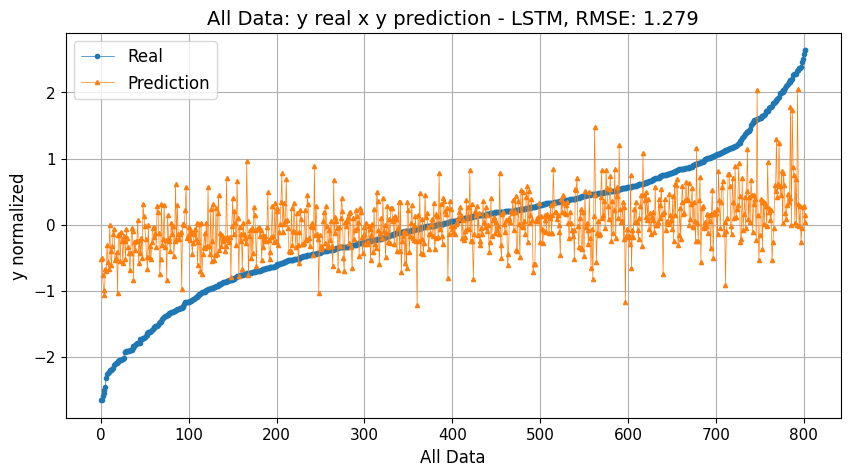

In [13]:
prediction_results = np.asarray(np.column_stack((y_scaled, y_pred_scaled)))
prediction_results = sorted(prediction_results, key= lambda x: x[0])
prediction_results = np.asarray(prediction_results)
plt.figure(figsize = (10,5))
plt.plot(np.asarray(np.asarray(prediction_results[:,0])), 
         linestyle='-', linewidth=0.5, marker='o', markersize=3, label = 'Real')
plt.plot(np.asarray(np.asarray(prediction_results[:,1])), 
         linestyle='-', linewidth=0.5, marker='^', markersize=3, label = 'Prediction')
plt.title('All Data: y real x y prediction - LSTM, RMSE: %.3f'
          %(rmse_dl), fontsize = 14)
plt.xlabel('All Data', fontsize = 12)
plt.ylabel('y normalized', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid()
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

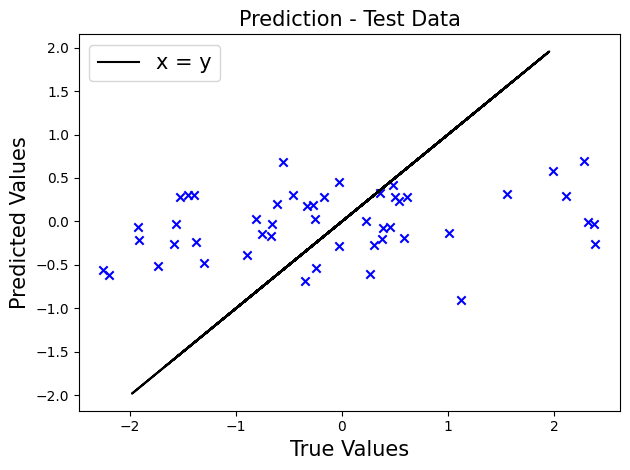

In [14]:
# Predicted vs True values - Test Data
plt.figure()
reta = np.random.uniform(low=-2, high=2, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(y_test_scaled, y_test_pred_scaled, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - Test Data', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/MODEL_{MODEL_ID}{DATA_ID}_{OUTPUT}_test_predictions.png')
plt.show()
plt.close()

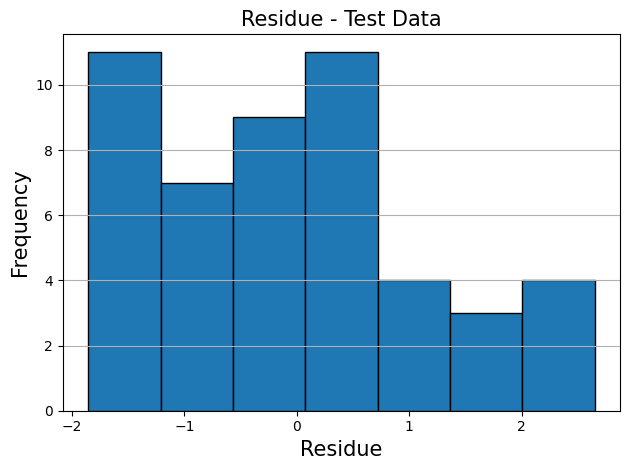

In [15]:
# Residue - Test Data
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue_test, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - Test Data', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/MODEL_{MODEL_ID}{DATA_ID}_{OUTPUT}_test_residue.png')
plt.show()
plt.close()

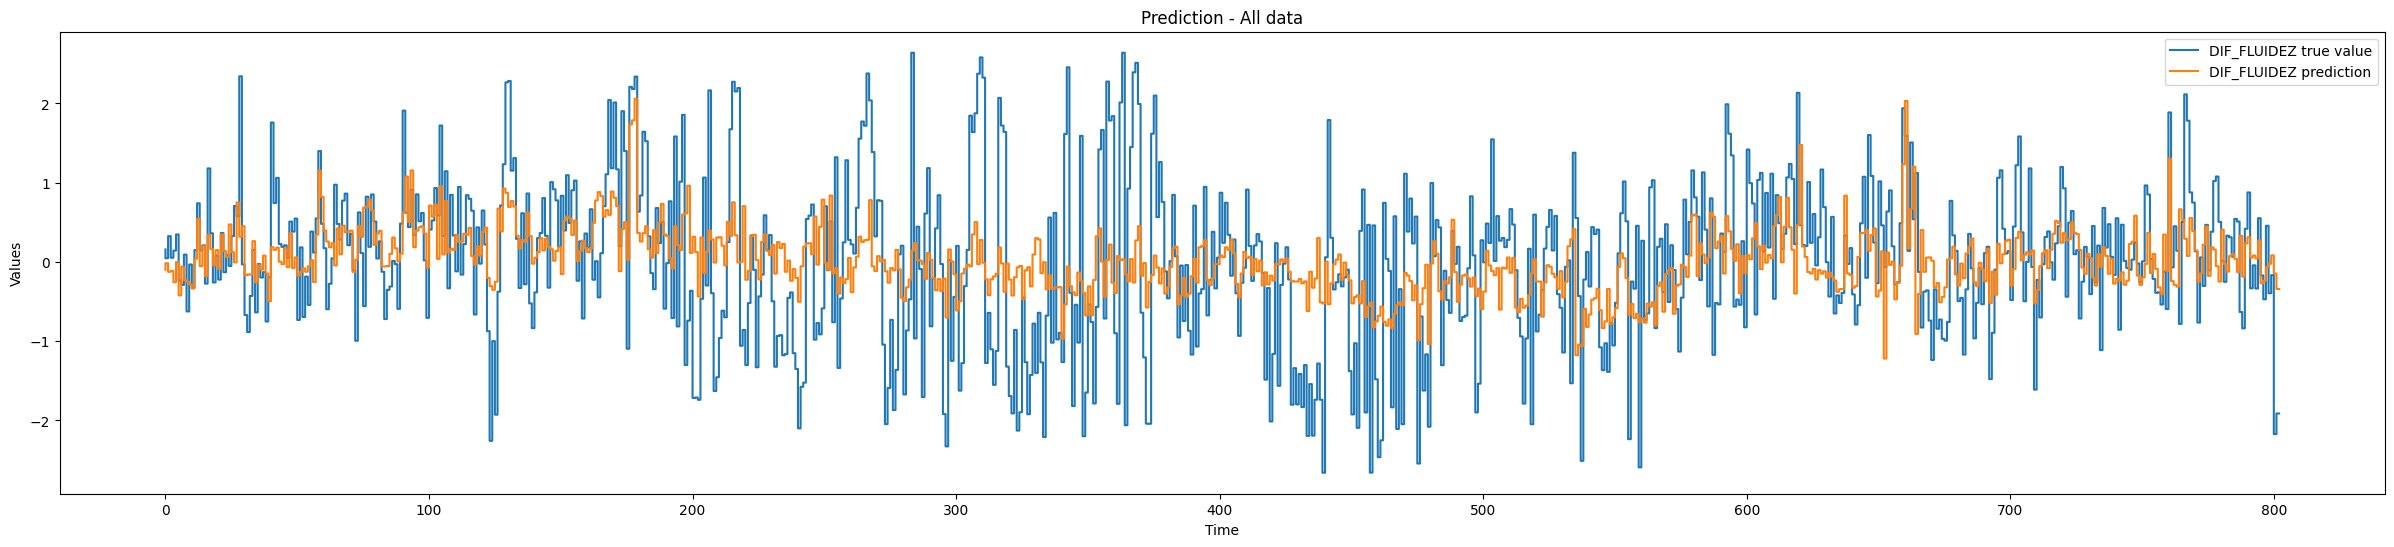

In [16]:
time_steps = np.arange(len(y_scaled))  # or use another array if available

# Predicted vs True values over time - All Data
plt.figure(figsize=(30, 6))
plt.step(time_steps, y_scaled, label=f'{OUTPUT} true value')
plt.step(time_steps, y_pred_scaled, label=f'{OUTPUT} prediction')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Prediction - All data')
plt.legend()
plt.savefig(f'{FIGURES_FOLDER}/MODEL_{MODEL_ID}{DATA_ID}_{OUTPUT}_alldata_prediction_time.png')
plt.show()

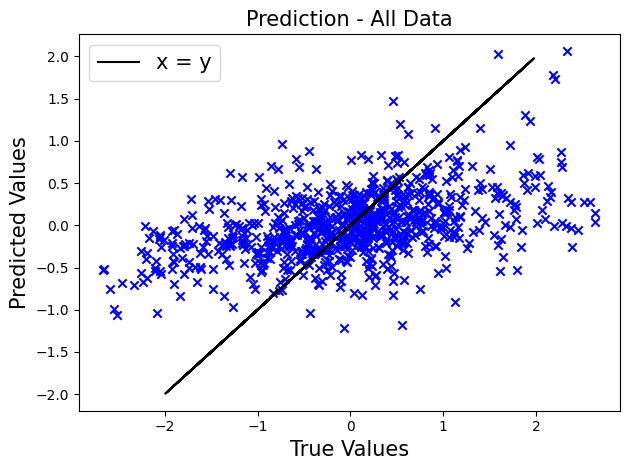

In [17]:
# Predicted vs True values - All Data
plt.figure()
reta = np.random.uniform(low=-2, high=2, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(y_scaled, y_pred_scaled, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - All Data', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/MODEL_{MODEL_ID}{DATA_ID}_{OUTPUT}_test_predictions.png')
plt.show()
plt.close()

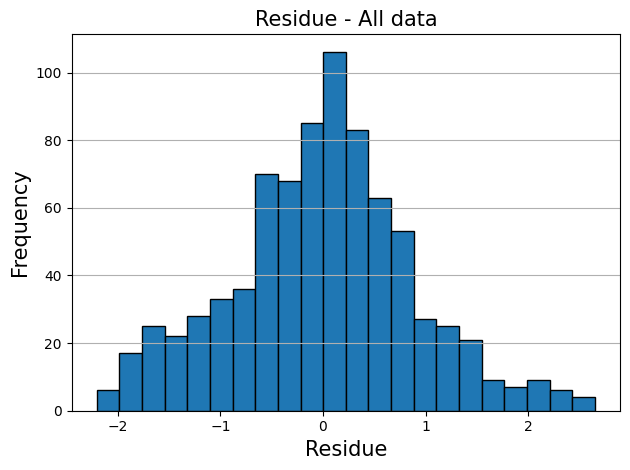

In [18]:
# Residue - All Data
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - All data', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/MODEL_{MODEL_ID}{DATA_ID}_{OUTPUT}_alldata_residue.png')
plt.show()
plt.close()

In [19]:
# Undo the scaling applied to y_scaled
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1)


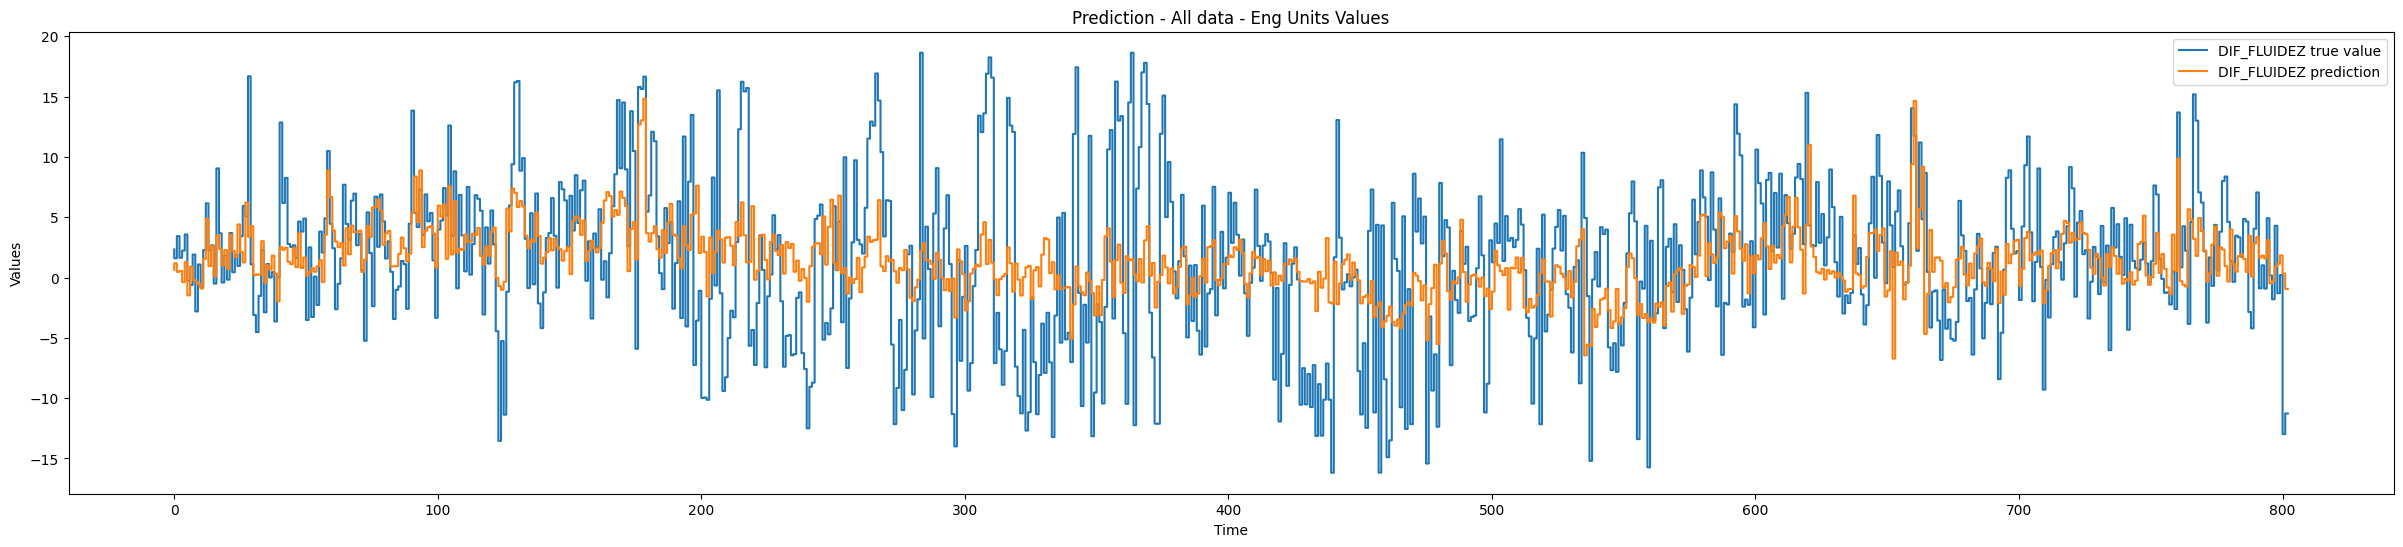

In [20]:
time_steps = np.arange(len(y))  # or use another array if available

# Predicted vs True values over time - All Data
plt.figure(figsize=(30, 6))
plt.step(time_steps, y, label=f'{OUTPUT} true value')
plt.step(time_steps, y_pred, label=f'{OUTPUT} prediction')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Prediction - All data - Eng Units Values')
plt.legend()
plt.savefig(f'{FIGURES_FOLDER}/MODEL_{MODEL_ID}{DATA_ID}_{OUTPUT}_alldata_prediction_time.png')
plt.show()